In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_data_from_kaggle():
    try:
        import os
        if os.path.exists('/kaggle/input'):
            base_path = '/kaggle/input'
            dataset_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
            if dataset_folders:
                data_path = os.path.join(base_path, dataset_folders[0])
            else:
                data_path = '.'

        main_df = pd.read_csv(f'{data_path}/autoinsurance_churn.csv')
        print(f" Main dataset loaded: {main_df.shape}")
        churn_counts = main_df['Churn'].value_counts()
        churn_rate = churn_counts.get(1, 0) / len(main_df) * 100
        scale_pos_weight = churn_counts.get(0, 1) / churn_counts.get(1, 1)

        print(f"\n Churn Distribution:")
        print(f"   No Churn (0): {churn_counts.get(0, 0):,} ({100-churn_rate:.2f}%)")
        print(f"   Churn (1): {churn_counts.get(1, 0):,} ({churn_rate:.2f}%)")
        print(f"   Imbalance Ratio: {scale_pos_weight:.2f}:1")

        return main_df, scale_pos_weight

    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

main_df, scale_pos_weight = load_data_from_kaggle()

 Main dataset loaded: (1680909, 22)

 Churn Distribution:
   No Churn (0): 1,487,453 (88.49%)
   Churn (1): 193,456 (11.51%)
   Imbalance Ratio: 7.69:1


In [3]:
def engineer_features_advanced(df):
    df_enhanced = df.copy()
    leakage_cols = ['acct_suspd_date', 'ACCT_SUSPD_DATE', 'individual_id', 'address_id', 'date_of_birth']
    cols_to_drop = [col for col in leakage_cols if col in df_enhanced.columns]
    df_enhanced = df_enhanced.drop(columns=cols_to_drop)
    print(f" Removed leakage columns: {cols_to_drop}")

    df_enhanced.columns = df_enhanced.columns.str.lower()
    feature_count = 0

    if 'cust_orig_date' in df_enhanced.columns:
        df_enhanced['cust_orig_date'] = pd.to_datetime(df_enhanced['cust_orig_date'], errors='coerce')
        reference_date = pd.Timestamp('2023-01-01')
        df_enhanced['account_age_days'] = (reference_date - df_enhanced['cust_orig_date']).dt.days
        df_enhanced['account_age_months'] = df_enhanced['account_age_days'] / 30
        df_enhanced['signup_month'] = df_enhanced['cust_orig_date'].dt.month
        df_enhanced['signup_quarter'] = df_enhanced['cust_orig_date'].dt.quarter
        df_enhanced['is_holiday_signup'] = df_enhanced['signup_month'].isin([11, 12, 1]).astype(int)
        df_enhanced = df_enhanced.drop(columns=['cust_orig_date'])
        feature_count += 5

    if 'days_tenure' in df_enhanced.columns:
        df_enhanced['tenure_years'] = df_enhanced['days_tenure'] / 365
        df_enhanced['tenure_months'] = df_enhanced['days_tenure'] / 30
        df_enhanced['new_customer'] = (df_enhanced['days_tenure'] <= 180).astype(int)
        df_enhanced['veteran_customer'] = (df_enhanced['days_tenure'] >= 1825).astype(int)
        df_enhanced['medium_term'] = ((df_enhanced['days_tenure'] > 365) & (df_enhanced['days_tenure'] < 1095)).astype(int)
        feature_count += 5

    if 'curr_ann_amt' in df_enhanced.columns:
        df_enhanced['premium_high'] = (df_enhanced['curr_ann_amt'] >= df_enhanced['curr_ann_amt'].quantile(0.75)).astype(int)
        df_enhanced['premium_low'] = (df_enhanced['curr_ann_amt'] <= df_enhanced['curr_ann_amt'].quantile(0.25)).astype(int)
        if 'tenure_years' in df_enhanced.columns:
            df_enhanced['revenue_per_tenure_year'] = df_enhanced['curr_ann_amt'] / (df_enhanced['tenure_years'] + 1)
            df_enhanced['lifetime_value'] = df_enhanced['curr_ann_amt'] * df_enhanced['tenure_years']
            feature_count += 2
        if 'income' in df_enhanced.columns:
            df_enhanced['income_to_premium_ratio'] = df_enhanced['income'] / (df_enhanced['curr_ann_amt'] + 1)
            df_enhanced['can_afford'] = (df_enhanced['income_to_premium_ratio'] > 20).astype(int)
            feature_count += 2
        feature_count += 2

    if 'age_in_years' in df_enhanced.columns:
        df_enhanced['age_group'] = pd.cut(df_enhanced['age_in_years'], bins=[0, 25, 35, 45, 55, 65, 100], labels=[1, 2, 3, 4, 5, 6])
        df_enhanced['senior_citizen'] = (df_enhanced['age_in_years'] >= 65).astype(int)
        df_enhanced['young_driver'] = (df_enhanced['age_in_years'] <= 25).astype(int)
        df_enhanced['middle_aged'] = ((df_enhanced['age_in_years'] > 35) & (df_enhanced['age_in_years'] <= 55)).astype(int)
        if 'tenure_years' in df_enhanced.columns:
            df_enhanced['age_tenure_ratio'] = df_enhanced['age_in_years'] / (df_enhanced['tenure_years'] + 1)
            feature_count += 1
        feature_count += 4

    if 'city' in df_enhanced.columns:
        city_counts = df_enhanced['city'].value_counts()
        df_enhanced['city_customer_count'] = df_enhanced['city'].map(city_counts)
        city_freq = city_counts / len(df_enhanced)
        df_enhanced['city_frequency'] = df_enhanced['city'].map(city_freq)
        df_enhanced['rare_city'] = (df_enhanced['city_frequency'] < 0.01).astype(int)
        feature_count += 3
    if 'latitude' in df_enhanced.columns and 'longitude' in df_enhanced.columns:
        center_lat, center_lon = 39.8283, -98.5795
        df_enhanced['distance_from_center'] = np.sqrt((df_enhanced['latitude'] - center_lat)**2 + (df_enhanced['longitude'] - center_lon)**2)
        if 'city' in df_enhanced.columns:
            city_centers = df_enhanced.groupby('city')[['latitude', 'longitude']].transform('mean')
            df_enhanced['distance_from_city_center'] = np.sqrt((df_enhanced['latitude'] - city_centers['latitude'])**2 + (df_enhanced['longitude'] - city_centers['longitude'])**2)
            feature_count += 1
        feature_count += 1

    if 'state' in df_enhanced.columns and 'curr_ann_amt' in df_enhanced.columns:
        state_stats = df_enhanced.groupby('state').agg({'curr_ann_amt': ['mean', 'std'], 'days_tenure': 'mean'})
        state_stats.columns = ['state_avg_premium', 'state_std_premium', 'state_avg_tenure']
        df_enhanced = df_enhanced.merge(state_stats, on='state', how='left')
        df_enhanced['premium_vs_state_avg'] = df_enhanced['curr_ann_amt'] / df_enhanced['state_avg_premium']
        feature_count += 4

    if 'home_market_value' in df_enhanced.columns and 'income' in df_enhanced.columns:
        if df_enhanced['home_market_value'].dtype == 'object':
            df_enhanced['home_value_numeric'] = df_enhanced['home_market_value'].str.extract(r'(\\d+)')[0].astype(float)
        else:
            df_enhanced['home_value_numeric'] = df_enhanced['home_market_value']
        df_enhanced['wealth_score'] = (df_enhanced['home_value_numeric'].fillna(0)/100000) + (df_enhanced['income']/10000)
        feature_count += 2
    if 'college_degree' in df_enhanced.columns:
        if 'wealth_score' in df_enhanced.columns:
            df_enhanced['wealth_score'] += df_enhanced['college_degree'] * 2
    if 'length_of_residence' in df_enhanced.columns and 'home_owner' in df_enhanced.columns:
        df_enhanced['stability_score'] = (df_enhanced['length_of_residence']/10) + df_enhanced['home_owner'].astype(int) * 2
        if 'marital_status' in df_enhanced.columns:
            df_enhanced['stability_score'] += (df_enhanced['marital_status'] == 'Married').astype(int)
        feature_count += 1

    df_enhanced['feature_completeness'] = df_enhanced.count(axis=1) / df_enhanced.shape[1]
    df_enhanced['missing_count'] = df_enhanced.isnull().sum(axis=1)
    feature_count += 2
    
    print(f" Created {feature_count} new engineered features")
    print(f" Total features now: {df_enhanced.shape[1]}")

    return df_enhanced

if main_df is not None:
    df_engineered = engineer_features_advanced(main_df)

 Removed leakage columns: ['acct_suspd_date', 'individual_id', 'address_id', 'date_of_birth']
 Created 35 new engineered features
 Total features now: 52


In [4]:
def preprocess_data(df, target_col='churn'):
    df_clean = df.copy()
    if target_col not in df_clean.columns:
        print(f" Target column '{target_col}' not found!")
        return None, None

    print(f" Target column: {target_col}")
    initial_missing = df_clean.isnull().sum().sum()

    all_numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in all_numeric_cols if col != target_col]

    for col in numeric_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    all_categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
    categorical_cols = [col for col in all_categorical_cols if col != target_col]

    for col in categorical_cols:
        mode_vals = df_clean[col].mode()
        if not mode_vals.empty:
            df_clean[col] = df_clean[col].fillna(mode_vals.iloc[0])
        else:
            df_clean[col] = df_clean[col].fillna('Unknown')

    final_missing = df_clean.isnull().sum().sum()
    print(f" Filled {initial_missing - final_missing:,} missing values")

    initial_rows = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f" Removed {initial_rows - len(df_clean):,} duplicates")

    outlier_count = 0
    dropped_cols = []

    for col in numeric_cols:
        try:
            col_series = df_clean[col]
            if not isinstance(col_series, pd.Series):
                dropped_cols.append(col)
                continue
            if col_series.apply(lambda x: isinstance(x, (list, np.ndarray, dict, pd.Series, pd.DataFrame))).any():
                dropped_cols.append(col)
                continue
            col_numeric = pd.to_numeric(col_series, errors='coerce')
            if col_numeric.dropna().empty:
                dropped_cols.append(col)
                continue
            Q1 = col_numeric.quantile(0.01)
            Q3 = col_numeric.quantile(0.99)
            if pd.isna(Q1) or pd.isna(Q3):
                dropped_cols.append(col)
                continue
            IQR = Q3 - Q1
            lower, upper = Q1 - 3 * IQR, Q3 + 3 * IQR
            mask = (col_numeric < lower) | (col_numeric > upper)
            outlier_count += mask.sum()
            df_clean[col] = np.clip(col_numeric, lower, upper)
        except Exception as e:
            dropped_cols.append(col)
            continue

    if dropped_cols:
        print(f" Skipped {len(dropped_cols)} problematic columns")

    print(f" Capped {outlier_count:,} outlier values")

    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col])
    if isinstance(y, pd.DataFrame):
        print(f" Warning: Multiple '{target_col}' columns found. Using first one.")
        y = y.iloc[:, 0]

    print(f" Features shape: {X.shape}")
    print(f" Target distribution:")

    churn_0_series = (y == 0).sum()
    churn_1_series = (y == 1).sum()
    if isinstance(churn_0_series, pd.Series):
        churn_0 = churn_0_series.values[0]
        churn_1 = churn_1_series.values[0]
    else:
        churn_0 = int(churn_0_series)
        churn_1 = int(churn_1_series)
    total = len(y)

    print(f"   No Churn (0): {churn_0:,} ({churn_0/total*100:.1f}%)")
    print(f"   Churn (1): {churn_1:,} ({churn_1/total*100:.1f}%)")

    return X, y

if 'df_engineered' in locals():
    X, y = preprocess_data(df_engineered)

 Target column: churn
 Filled 1,169,018 missing values
 Removed 0 duplicates
 Skipped 1 problematic columns
 Capped 1,647 outlier values
 Features shape: (1680909, 51)
 Target distribution:
   No Churn (0): 1,487,453 (88.5%)
   Churn (1): 193,456 (11.5%)


In [5]:
def encode_features(X, y):
    X_encoded = X.copy()
    id_cols = [col for col in X_encoded.columns if 'id' in col.lower()]
    if id_cols:
        X_encoded = X_encoded.drop(columns=id_cols)
        print(f" Dropped ID columns: {id_cols}")
    date_cols = X_encoded.select_dtypes(include=['datetime64']).columns.tolist()
    if date_cols:
        X_encoded = X_encoded.drop(columns=date_cols)
        print(f" Dropped date columns: {date_cols}")
    
    categorical_cols = X_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
    print(f" Encoded {len(categorical_cols)} categorical columns")
    
    from sklearn.feature_selection import VarianceThreshold
    initial_features = X_encoded.shape[1]
    selector = VarianceThreshold(threshold=0.01)
    X_encoded = pd.DataFrame(selector.fit_transform(X_encoded), columns=X_encoded.columns[selector.get_support()])
    removed = initial_features - X_encoded.shape[1]
    print(f" Removed {removed} low-variance features")
    print(f" Final feature count: {X_encoded.shape[1]}")
    feature_names = X_encoded.columns.tolist()
    return X_encoded, y, label_encoders, feature_names

if 'X' in locals() and X is not None:
    X_processed, y, label_encoders, feature_names = encode_features(X, y)

 Dropped ID columns: ['length_of_residence', 'is_holiday_signup', 'middle_aged']
 Encoded 6 categorical columns
 Removed 9 low-variance features
 Final feature count: 39


In [6]:
def create_train_test_split(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    print(f"\n Split Statistics:")
    print(f"   Training set: {X_train.shape[0]:,} samples ({(1-test_size)*100:.0f}%)")
    print(f"   Test set: {X_test.shape[0]:,} samples ({test_size*100:.0f}%)")
    print(f"   Features: {X_train.shape[1]}")
    print(f"\n Training set distribution:")
    print(f"   No Churn: {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
    print(f"   Churn: {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
    print(f"\n Test set distribution:")
    print(f"   No Churn: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
    print(f"   Churn: {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
    return X_train, X_test, y_train, y_test

if 'X_processed' in locals():
    X_train, X_test, y_train, y_test = create_train_test_split(X_processed, y)


 Split Statistics:
   Training set: 1,344,727 samples (80%)
   Test set: 336,182 samples (20%)
   Features: 39

 Training set distribution:
   No Churn: 1,189,962 (88.5%)
   Churn: 154,765 (11.5%)

 Test set distribution:
   No Churn: 297,491 (88.5%)
   Churn: 38,691 (11.5%)


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV

def optimize_gradientboost_hyperparameters_balanced(X_train, y_train, sample_size=5000):
    print(f"\n HYPERPARAMETER OPTIMIZATION WITH BALANCED STRATIFIED SAMPLE")

    # Stratified sampling
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
    for train_index, _ in splitter.split(X_train, y_train):
        X_sample = X_train.iloc[train_index]
        y_sample = y_train.iloc[train_index]

    print(f"Sampled {len(X_sample)} rows for tuning with stratified sampling")

    param_distributions = {
        'n_estimators': [200, 300],
        'max_depth': [3, 4],
        'learning_rate': [0.03, 0.1],
        'subsample': [0.7, 0.9],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }

    gboost_model = GradientBoostingClassifier(
        random_state=42,
        warm_start=True  
    )

    random_search = RandomizedSearchCV(
        gboost_model,
        param_distributions=param_distributions,
        n_iter=10,
        scoring='roc_auc',
        cv=2,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_sample, y_sample)

    print(f"\n OPTIMIZATION COMPLETE")
    print(f" Best CV ROC-AUC: {random_search.best_score_:.4f}")
    print(f"\n Best Parameters:")
    for param, value in random_search.best_params_.items():
        print(f"   {param:20s}: {value}")

    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

if 'X_train' in locals():
    best_model, best_params, best_cv_score = optimize_gradientboost_hyperparameters_balanced(X_train, y_train, sample_size=5000)



 HYPERPARAMETER OPTIMIZATION WITH BALANCED STRATIFIED SAMPLE
Sampled 5000 rows for tuning with stratified sampling
Fitting 2 folds for each of 10 candidates, totalling 20 fits

 OPTIMIZATION COMPLETE
 Best CV ROC-AUC: 0.6732

 Best Parameters:
   subsample           : 0.7
   n_estimators        : 200
   min_samples_split   : 2
   min_samples_leaf    : 2
   max_features        : sqrt
   max_depth           : 4
   learning_rate       : 0.03



 THRESHOLD OPTIMIZATION

 Default threshold (0.5):
   Precision: 0.4891
   Recall: 0.2154
   F1 Score: 0.2991

 Optimal threshold (0.2394):
   Precision: 0.4653
   Recall: 0.3982
   F1 Score: 0.4292


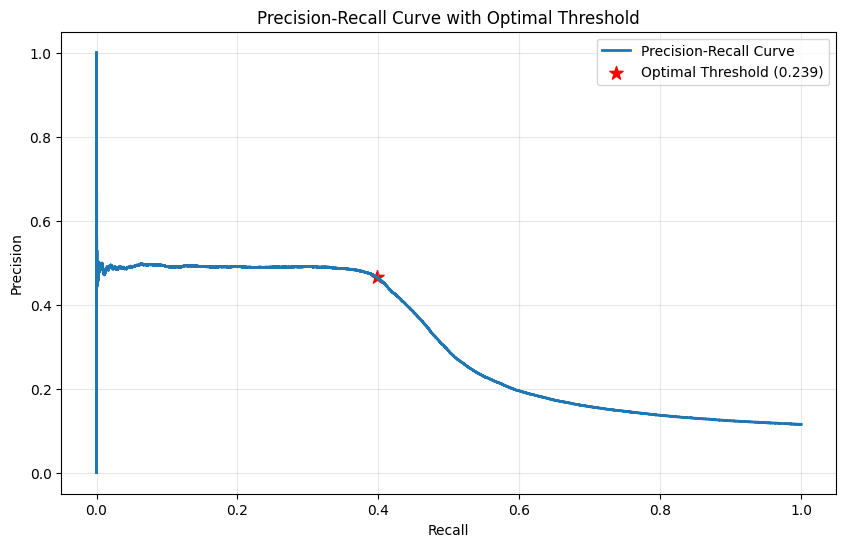

In [11]:
def optimize_threshold(model, X_test, y_test):
    print(f"\n THRESHOLD OPTIMIZATION\n")
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

    print(f" Default threshold (0.5):")
    y_pred_default = (y_pred_proba >= 0.5).astype(int)
    print(f"   Precision: {precision_score(y_test, y_pred_default):.4f}")
    print(f"   Recall: {recall_score(y_test, y_pred_default):.4f}")
    print(f"   F1 Score: {f1_score(y_test, y_pred_default):.4f}")

    print(f"\n Optimal threshold ({optimal_threshold:.4f}):")
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)
    print(f"   Precision: {precision_score(y_test, y_pred_optimized):.4f}")
    print(f"   Recall: {recall_score(y_test, y_pred_optimized):.4f}")
    print(f"   F1 Score: {f1_score(y_test, y_pred_optimized):.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(recalls, precisions, linewidth=2, label='Precision-Recall Curve')
    plt.scatter(recalls[optimal_idx], precisions[optimal_idx], c='red', s=100, marker='*', label=f'Optimal Threshold ({optimal_threshold:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve with Optimal Threshold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return optimal_threshold, y_pred_optimized

if 'best_model' in locals():
    optimal_threshold, y_pred_optimized = optimize_threshold(best_model, X_test, y_test)

In [12]:
def evaluate_model_comprehensive(model, X_train, X_test, y_train, y_test, y_pred=None):
    print(f"\n MODEL EVALUATION\n")
    if y_pred is None:
        y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]

    print(f"\n TRAINING SET PERFORMANCE:")
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_pred_train),
        'Precision': precision_score(y_train, y_pred_train, zero_division=0),
        'Recall': recall_score(y_train, y_pred_train, zero_division=0),
        'F1 Score': f1_score(y_train, y_pred_train, zero_division=0),
        'ROC-AUC': roc_auc_score(y_train, y_pred_proba_train)
    }
    for metric, value in train_metrics.items():
        print(f"   {metric:12s}: {value:.4f}")

    print(f"\n TEST SET PERFORMANCE:")
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_test)
    }
    for metric, value in test_metrics.items():
        print(f"   {metric:12s}: {value:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print(f"\n CONFUSION MATRIX:")
    print(f"   Predicted →   No Churn    Churn")
    print(f"   Actual ↓")
    print(f"   No Churn      {cm[0,0]:8,} {cm[0,1]:8,}")
    print(f"   Churn         {cm[1,0]:8,} {cm[1,1]:8,}")

    tn, fp, fn, tp = cm.ravel()
    print(f"\n   True Negatives:  {tn:,}")
    print(f"   True Positives:  {tp:,}")
    print(f"   False Positives: {fp:,}")
    print(f"   False Negatives: {fn:,}")
    print(f"\n   Churn Detection Rate: {tp/(fn+tp)*100:.2f}%")
    print(f"   False Alarm Rate: {fp/(fp+tn)*100:.2f}%")

    return test_metrics, cm

if 'best_model' in locals() and 'y_pred_optimized' in locals():
    test_metrics, cm = evaluate_model_comprehensive(best_model, X_train, X_test, y_train, y_test, y_pred_optimized)


 MODEL EVALUATION


 TRAINING SET PERFORMANCE:
   Accuracy    : 0.8848
   Precision   : 0.4993
   Recall      : 0.2202
   F1 Score    : 0.3056
   ROC-AUC     : 0.6948

 TEST SET PERFORMANCE:
   Accuracy    : 0.8781
   Precision   : 0.4653
   Recall      : 0.3982
   F1 Score    : 0.4292
   ROC-AUC     : 0.6919

 CONFUSION MATRIX:
   Predicted →   No Churn    Churn
   Actual ↓
   No Churn       279,785   17,706
   Churn           23,283   15,408

   True Negatives:  279,785
   True Positives:  15,408
   False Positives: 17,706
   False Negatives: 23,283

   Churn Detection Rate: 39.82%
   False Alarm Rate: 5.95%


In [14]:
def save_model_artifacts(model, label_encoders, feature_names, optimal_threshold, best_params):
    print(f"\n SAVING MODEL ARTIFACTS\n{'='*70}")
    joblib.dump(model, 'churn_gradboost_optimized.pkl')
    print(" Model saved: churn_gradboost_optimized.pkl")
    artifacts = {
        'label_encoders': label_encoders,
        'feature_names': feature_names,
        'optimal_threshold': optimal_threshold,
        'best_params': best_params
    }
    joblib.dump(artifacts, 'model_artifacts.pkl')
    print(" Artifacts saved: model_artifacts.pkl")
    print("\n Model ready for deployment!")

if 'best_model' in locals():
    save_model_artifacts(best_model, label_encoders, feature_names, optimal_threshold, best_params)

print(f"\n\n{'='*80}")
print("COMPLETE AUTO INSURANCE CHURN PREDICTION PIPELINE FINISHED")
print(f"{'='*80}")
print(f"\nFinal Results:")
print(f"   Best CV ROC-AUC: {best_cv_score:.4f}")
print(f"   Test F1 Score: {test_metrics['F1 Score']:.4f}")
print(f"   Test Recall: {test_metrics['Recall']:.4f}")
print(f"   Optimal Threshold: {optimal_threshold:.4f}")
print(f"\nModel is ready for production deployment!")



 SAVING MODEL ARTIFACTS
 Model saved: churn_gradboost_optimized.pkl
 Artifacts saved: model_artifacts.pkl

 Model ready for deployment!


COMPLETE AUTO INSURANCE CHURN PREDICTION PIPELINE FINISHED

Final Results:
   Best CV ROC-AUC: 0.6732
   Test F1 Score: 0.4292
   Test Recall: 0.3982
   Optimal Threshold: 0.2394

Model is ready for production deployment!
